In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Neccessary Libraries

In [0]:
import numpy as np
import pandas as pd
import math
import os
import seaborn as sn
import glob
from google.colab import drive
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D, Dropout, Flatten, AvgPool1D, AvgPool2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import optimizers
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


#Pre-Processing of Data

In [0]:
flight_data = pd.read_csv(r'/content/drive/My Drive/Ashwin/Machine Learning/Project/final dataset.csv')

In [0]:
flight_data.info()
print(flight_data.shape)
print(flight_data.columns)
pd.isnull(flight_data).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37731 entries, 0 to 37730
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AIRLINE                   37731 non-null  object 
 1   FROM_JFK                  37731 non-null  object 
 2   TO JFK                    37731 non-null  object 
 3   SCHEDULED_DEPARTURE_TIME  37731 non-null  float64
 4   FEDERAL_HOLIDAY           1132 non-null   float64
 5   STATE_HOLIDAY             577 non-null    float64
 6   WEEKEND                   16393 non-null  float64
 7   LONG_WEEKEND              2050 non-null   float64
 8   WIND_DIRECTION            37731 non-null  int64  
 9   WIND SPEED                37731 non-null  int64  
 10  ALTIMETER                 37731 non-null  float64
 11  0.0slp                    37731 non-null  float64
 12  t0.0pc                    37731 non-null  float64
 13  VISIBILITY                37731 non-null  float64
 14  DEPART

AIRLINE                         0
FROM_JFK                        0
TO JFK                          0
SCHEDULED_DEPARTURE_TIME        0
FEDERAL_HOLIDAY             36599
STATE_HOLIDAY               37154
WEEKEND                     21338
LONG_WEEKEND                35681
WIND_DIRECTION                  0
WIND SPEED                      0
ALTIMETER                       0
0.0slp                          0
t0.0pc                          0
VISIBILITY                      0
DEPARTURE_TIME                  0
SCHEDULED_ARRIVAL               0
ARRIVAL_TIME                    0
SCHEDULED_TIME                  0
ELAPSED_TIME                    0
DEPARTURE_DELAY                 0
ARRIVAL_DELAY                   0
AIR_SYSTEM_DELAY                0
SECURITY_DELAY                  0
AIRLINE_DELAY                   0
LATE_AIRCRAFT_DELAY             0
WEATHER_DELAY                   0
CANCELLED                       0
dtype: int64

In [0]:
flight_data = flight_data.fillna(int(0))

In [0]:
for i in range(flight_data.shape[0]):
  code = str(flight_data.iloc[i, 1])
  if code == 'JFK':
    flight_data.iloc[i, 1] = int(1)
  else:
    flight_data.iloc[i, 1] = int(0)
    
for i in range(flight_data.shape[0]):
  code = str(flight_data.iloc[i, 2])
  if code == 'JFK':
    flight_data.iloc[i, 2] = int(1)
  else:
    flight_data.iloc[i, 2] = int(0)

In [0]:
dropesh = ['AIRLINE']
flight_data = flight_data.drop(dropesh, axis = 1)


In [0]:
flight_data[['FROM_JFK', 'TO JFK', 'FEDERAL_HOLIDAY', 'STATE_HOLIDAY', 'WEEKEND', 'LONG_WEEKEND']] = flight_data[['FROM_JFK', 'TO JFK', 'FEDERAL_HOLIDAY', 'STATE_HOLIDAY', 'WEEKEND', 'LONG_WEEKEND']].apply(pd.to_numeric)

In [0]:
EARLY_DEPARTURE = []
EARLY_ARRIVAL = []
for col_no in range(18, 26):
  for i in range(flight_data.shape[0]):
    value = flight_data.iloc[i, col_no]
    if value > 0:
      flight_data.iloc[i, col_no] = int(1)
      if col_no == 18:
        EARLY_DEPARTURE.append(0)
      elif col_no == 19:
        EARLY_ARRIVAL.append(0)

    else:
      if col_no == 18:
        EARLY_DEPARTURE.append(1)
      elif col_no == 19:
        EARLY_ARRIVAL.append(1)
      flight_data.iloc[i, col_no] = int(0)
flight_data["EARLY_DEPARTURE"] = EARLY_DEPARTURE
flight_data["EARLY_ARRIVAL"] = EARLY_ARRIVAL

In [0]:
#flight_data.to_csv(r'/content/drive/My Drive/Ashwin/Machine Learning/Project/data.csv')

In [0]:
test = flight_data.columns[18:]
X = flight_data.copy(deep = True)
X.shape
X = X.drop(test,  axis = 1)
Y = flight_data[test]
Y = Y.drop(["EARLY_ARRIVAL", "EARLY_DEPARTURE"], axis = 1)

In [0]:
#Centralizing the Data Using Standard Scaler
X = np.array(X)
Y = np.array(Y)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X

array([[-1.00039763,  1.00039763, -2.305589  , ..., -1.27045671,
         0.10656148,  0.35580707],
       [-1.00039763,  1.00039763, -1.59504119, ..., -1.02530409,
        -1.24190594, -1.08928869],
       [-1.00039763,  1.00039763, -1.59504119, ..., -1.06032589,
        -1.26942568, -1.18279488],
       ...,
       [ 0.99960253, -0.99960253, -0.69501397, ..., -0.11473722,
         1.57428112,  1.39287579],
       [-1.00039763,  1.00039763, -0.69501397, ..., -0.35988984,
        -1.23273269, -1.063787  ],
       [ 0.99960253, -0.99960253, -0.69501397, ..., -0.00967181,
         0.10656148,  0.10079017]])

In [0]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size = 0.15, random_state =777)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_dev, Y_dev, test_size = 0.2, random_state = 777)

In [0]:
Model1 = Sequential()
Model1.add(Dense(60, input_dim = 18, kernel_regularizer=l2(1e-1), activation='relu'))
Model1.add(Dense(180, kernel_regularizer=l2(1e-1), activation= 'relu'))
Model1.add(Dense(320, kernel_regularizer=l2(1e-1), activation='relu'))
Model1.add(Dropout(0.3))
Model1.add(Dense(320, kernel_regularizer=l2(1e-1), activation='relu'))
Model1.add(Dropout(0.3))
Model1.add(Dense(160, kernel_regularizer=l2(1e-1), activation='relu'))
Model1.add(Dense(80, kernel_regularizer=l2(1e-1), activation='relu'))
Model1.add(Dense(40, kernel_regularizer=l2(1e-1), activation='relu'))
Model1.add(Dropout(0.3))
Model1.add(Dense(20, kernel_regularizer=l2(1e-1), activation='relu'))
Model1.add(Dense(18, kernel_regularizer=l2(1e-1), activation= 'relu'))
Model1.add(Dense(14, kernel_regularizer=l2(1e-1),  activation='relu'))
Model1.add(Dense(12, kernel_regularizer=l2(1e-1),  activation='relu'))
Model1.add(Dense(8, kernel_regularizer=l2(1e-1),  activation='sigmoid'))

#RMS_prop = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.09, epsilon=1e-07, centered=False)
sgd = SGD(lr = 0.00001, momentum = 0.009 ,clipvalue = 5, nesterov = True)
#adam = keras.optimizers.Adam(learning_rate = 0.00001, beta_1=0.09, beta_2=0.099, amsgrad = False)
Model1.compile(loss= 'binary_crossentropy', optimizer = sgd, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss',mode='min')
history1 = Model1.fit(X_train, Y_train, epochs = 50, validation_data = (X_dev, Y_dev), verbose = 2, callbacks = [es])

Train on 32071 samples, validate on 4528 samples
Epoch 1/50
 - 5s - loss: 113.2663 - accuracy: 0.4445 - val_loss: 113.0364 - val_accuracy: 0.4400
Epoch 2/50
 - 5s - loss: 112.8109 - accuracy: 0.4602 - val_loss: 112.5819 - val_accuracy: 0.4636
Epoch 3/50
 - 5s - loss: 112.3574 - accuracy: 0.4757 - val_loss: 112.1293 - val_accuracy: 0.4965
Epoch 4/50
 - 5s - loss: 111.9057 - accuracy: 0.4944 - val_loss: 111.6786 - val_accuracy: 0.5316
Epoch 5/50
 - 5s - loss: 111.4559 - accuracy: 0.5133 - val_loss: 111.2297 - val_accuracy: 0.5615
Epoch 6/50
 - 5s - loss: 111.0079 - accuracy: 0.5311 - val_loss: 110.7827 - val_accuracy: 0.5865
Epoch 7/50
 - 5s - loss: 110.5618 - accuracy: 0.5496 - val_loss: 110.3376 - val_accuracy: 0.6121
Epoch 8/50
 - 5s - loss: 110.1175 - accuracy: 0.5657 - val_loss: 109.8943 - val_accuracy: 0.6378
Epoch 9/50
 - 5s - loss: 109.6750 - accuracy: 0.5807 - val_loss: 109.4528 - val_accuracy: 0.6577
Epoch 10/50
 - 5s - loss: 109.2344 - accuracy: 0.5964 - val_loss: 109.0132 - v

In [0]:
_, tacc = Model1.evaluate(X_test, Y_test)
print("Test Accuracy is: " + str(tacc * 100)+ str("%"))


1132/1132 [==============================] - 0s 49us/step
Test Accuracy is: 82.38736987113953%


In [0]:
Model2 = Sequential()
Model2.add(Dense(60, input_dim = 18, kernel_regularizer=l2(1e-1), activation='relu'))
Model2.add(Dense(180, kernel_regularizer=l2(1e-1), activation= 'relu'))
Model2.add(Dense(320, kernel_regularizer=l2(1e-1), activation='relu'))
Model2.add(Dropout(0.3))
Model2.add(Dense(320, kernel_regularizer=l2(1e-1), activation='relu'))
Model2.add(Dropout(0.3))
Model2.add(Dense(160, kernel_regularizer=l2(1e-1), activation='relu'))
Model2.add(Dense(80, kernel_regularizer=l2(1e-1), activation='relu'))
Model2.add(Dense(40, kernel_regularizer=l2(1e-1), activation='relu'))
Model2.add(Dropout(0.3))
Model2.add(Dense(20, kernel_regularizer=l2(1e-1), activation='relu'))
Model2.add(Dense(18, kernel_regularizer=l2(1e-1), activation= 'relu'))
Model2.add(Dense(14, kernel_regularizer=l2(1e-1),  activation='relu'))
Model2.add(Dense(12, kernel_regularizer=l2(1e-1),  activation='relu'))
Model2.add(Dense(8, kernel_regularizer=l2(1e-1),  activation='sigmoid'))

#RMS_prop = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.09, epsilon=1e-07, centered=False)
#sgd = SGD(lr = 0.00001, momentum = 0.009 ,clipvalue = 5, nesterov = True)
adam = keras.optimizers.Adam(learning_rate = 0.01, beta_1=0.09, beta_2=0.999, amsgrad = False)
Model2.compile(loss= 'binary_crossentropy', optimizer = adam, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss',mode='min')
history2 = Model2.fit(X_train, Y_train, epochs = 5, validation_data = (X_dev, Y_dev), verbose = 2, callbacks = [es])

Train on 32071 samples, validate on 4528 samples
Epoch 1/5
 - 5s - loss: 1.1492 - accuracy: 0.8244 - val_loss: 0.6052 - val_accuracy: 0.8266
Epoch 2/5
 - 5s - loss: 0.6518 - accuracy: 0.8254 - val_loss: 0.6693 - val_accuracy: 0.8266


In [0]:
_, tacc = Model2.evaluate(X_test, Y_test)
print("Test Accuracy is: " + str(tacc * 100)+ str("%"))

1132/1132 [==============================] - 0s 44us/step
Test Accuracy is: 82.37632513046265%


In [0]:
data  = pd.read_csv(r'/content/drive/My Drive/Ashwin/Machine Learning/Project/data.csv')
data = data.drop(['Unnamed: 0'], axis = 1)
delay_labels = data.columns[18:]
delay_data = data[delay_labels]
data1 = delay_data.corr(method = 'pearson')
data2 = data[['FEDERAL_HOLIDAY',
       'STATE_HOLIDAY', 'WEEKEND', 'LONG_WEEKEND', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY']]

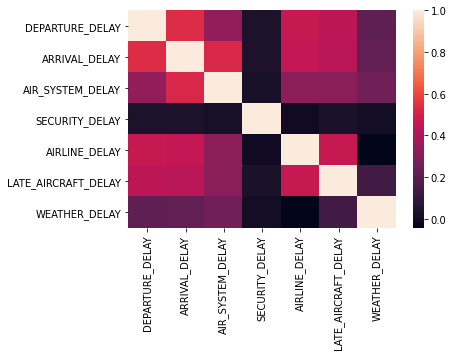

In [0]:
sn.heatmap(data1)

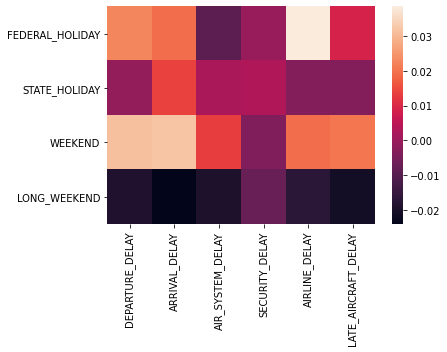

In [0]:
df = pd.DataFrame(data2.corr(method = 'pearson'))
sn.heatmap(df[df.columns[4:]][0:4])